# Results

In [19]:
# Import network graph
import lib.notebook_finder as notebook_finder
import autoencoder
from IPython.display import Image as iImage
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

# import packages from other notebook
exec(autoencoder.cells[0])

# import train/validation/test data
exec(autoencoder.cells[1])

# patch size used
exec(autoencoder.cells[2])

# Import network graph
exec(autoencoder.cells[3])

Train shape: (15000, 100, 100), (15000, 150, 150)
Test shape: (2500, 100, 100), (2500, 150, 150)
Valid shape: (2500, 100, 100), (2500, 150, 150)


## Define trained checkpoint

In [20]:
checkpoint = './model/model_global_step_2000000_chart_step_4001.ckpt'

## Metrics

The metric chosen, represents the difference between pixels colors.

In [21]:
# Metrics function
exec(autoencoder.cells[4])

print("when images are the same: %f" % difference(np.array([0,1,0]), np.array([0,1,0])))
print("when images are completely different: %f" % difference(np.array([0,1,0]), np.array([1,0,1])))

def get_patches(dataset, labels, batch_start):
    """ Given an X,y array, return image patches """
    batch_data = np.empty((batch_size, patch_size[0]*patch_size[1]))
    batch_labels = np.empty((batch_size, patch_size_out[0]*patch_size_out[1]))
    
    for i in range(batch_size):
        
        x = random.randint(0, dataset.shape[1] - patch_size[0])
        y = random.randint(0, dataset.shape[2] - patch_size[1])
        patch_scale = float(patch_size_out[0])/patch_size[0]
        data_w = dataset[batch_start+i, x: x+patch_size[0], y: y+patch_size[1]]
        label_w = labels[
            batch_start+i, 
            int(x*patch_scale) : int((x+patch_size[0])*patch_scale), 
            int(y*patch_scale): int((y+patch_size[1])*patch_scale)
        ]

        batch_data[i] = np.array(data_w).reshape((1, batch_data.shape[1]))
        batch_labels[i] = np.array(label_w).reshape((1, batch_labels.shape[1]))
    return (batch_data, batch_labels)

with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    if not checkpoint is None:
        saver.restore(session, checkpoint)
        
        # Validation score
        valid_batches = int(X_valid.shape[0]/batch_size)
        v_total = []
        for i in range(valid_batches):
            offset = i * batch_size
            valid_data, valid_labels = get_patches(X_valid, y_valid, offset)
            valid_predictions = session.run(y_pred, feed_dict= {
                tf_X : valid_data
            })
            v_total.append(difference(valid_predictions, valid_labels))
        v_diff = sum(v_total) / len(v_total)

        # Test score
        t_total = []
        test_batches = int(X_test.shape[0]/batch_size)
        for i in range(test_batches):
            offset = i * batch_size
            test_data, test_labels = get_patches(X_test, y_test, offset)
            test_predictions = session.run(y_pred, feed_dict= {
                tf_X : test_data
            })
            t_total.append(difference(test_predictions, test_labels))
        t_diff = sum(t_total) / len(t_total)
        
        print("Test r2: %.3f" % t_diff)
        print("Validation r2: %.3f" % v_diff)


when images are the same: 0.000000
when images are completely different: 1.000000
Test r2: 0.064
Validation r2: 0.063


## Show patches

Train results


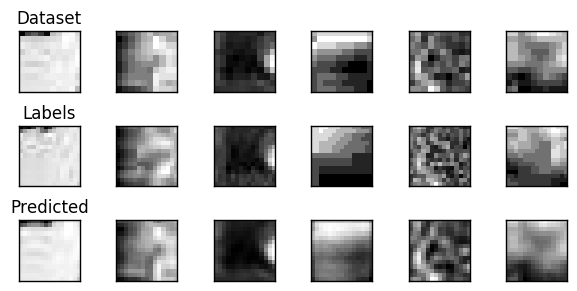

Test results


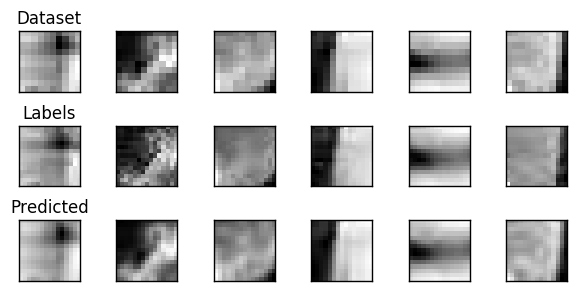

In [24]:
examples_to_show = 6

def show_plot(train, labels, predictions):
    """ Print an image grid """
    
    row_names = ("Dataset", "Labels", "Predicted")
    # Compare original images with their reconstructions
    f, a = plt.subplots(3, examples_to_show, figsize=(examples_to_show, 3))
    # Hide labels
    for axis in f.axes:
        axis.set_xticks([])
        axis.set_yticks([])
    # Row names
    for axis, row_name in zip(a[:,0], row_names):
        axis.set_title(row_name)

    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(train[i], patch_size), cmap="gray", interpolation="nearest")
        a[1][i].imshow(np.reshape(labels[i], patch_size_out), cmap="gray", interpolation="nearest")
        a[2][i].imshow(np.reshape(predictions[i], patch_size_out), cmap="gray", interpolation="nearest")
    f.tight_layout()
    plt.show()


with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    saver.restore(session, checkpoint)
    
    t_total = []
    train_batches = 3 # train n samples of 256 patches. We don't need everything to draw a graph
    for i in range(train_batches):
        offset = i * batch_size
        train_data, train_labels = get_patches(X_train, y_train, offset)
        train_predictions = session.run(y_pred, feed_dict= {
            tf_X : train_data
        })
        t_total.append(difference(train_predictions, train_labels))
    t_diff = sum(t_total) / len(t_total)

    # Validation score
    valid_batches = int(X_valid.shape[0]/batch_size)
    v_total = []
    for i in range(valid_batches):
        offset = i * batch_size
        valid_data, valid_labels = get_patches(X_valid, y_valid, offset)
        valid_predictions = session.run(y_pred, feed_dict= {
            tf_X : valid_data
        })
        v_total.append(difference(valid_predictions, valid_labels))
    v_diff = sum(v_total) / len(v_total)

    # Validation images
    random_batch = random.randint(0, valid_batches-1)
    valid_data, valid_labels = get_patches(X_valid, y_valid, random_batch * batch_size)
    valid_predictions = session.run(y_pred, feed_dict= {
        tf_X : valid_data
    })

    clear_output()

    print("Train results")
    show_plot(train_data, train_labels, train_predictions)

    print("Test results")
    show_plot(valid_data, valid_labels, valid_predictions)



## Recompose an image

Low-res


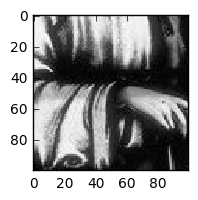

Neural net output
R2: 0.0922741219489


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


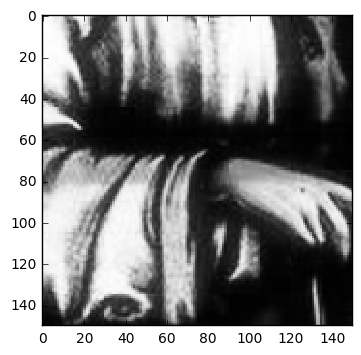

Nearest neighbor
R2: 0.120238


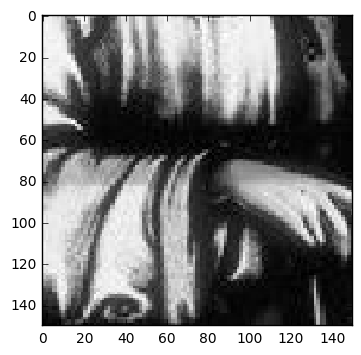

High-res


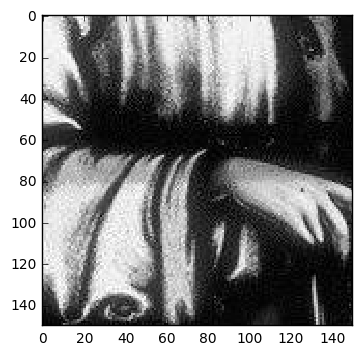

In [27]:
def decompose_image(image, patch_size):
    decomposed = np.empty(((image.shape[0]*image.shape[1]) / (patch_size[0]*patch_size[1]),) + patch_size)
    i = 0;
    for x in range(patch_size[0]):
        for y in range(patch_size[1]):
            x_ = int(x * patch_size[0])
            y_ = int(y * patch_size[1])
            decomposed[i] = image[x_:x_+patch_size[0], y_:y_+patch_size[1]]
            i += 1
    return decomposed

def recompose_image(image, out_size):
    recomposed = np.empty(out_size)
    i = 0;
    for y in range(out_size[1] // image.shape[2]):
        for x in range(out_size[0] // image.shape[1]):
            x_ = int(x * image.shape[1])
            y_ = int(y * image.shape[2])
            recomposed[y_:y_+image.shape[1], x_:x_+image.shape[2]] = image[i]
            i += 1
    return recomposed


with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    if not checkpoint is None:
        saver.restore(session, checkpoint)
    
    # Pick a random image from the test set
    r = random.randint(0, X_test.shape[0])
    image = X_test[r]
    label = y_test[r]
    
    # Show it
    print("Low-res")
    plt.figure(figsize = (2, 2))
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.show()
    
    # Break it into small patches to be able to process it
    data = decompose_image(image, patch_size)
    data = data.reshape((-1, patch_size[0]*patch_size[1]))
    
    out_data = np.zeros((data.shape[0], n_output))
    
    # Run it through the network to optimize it
    for i in range(math.ceil(out_data.shape[0]/batch_size)):
        # extract this batch
        batch_range = range(i*batch_size, min((i+1)*batch_size, out_data.shape[0]))
        # Last batch may be smaller... creating a fixed size array and feeding data in
        batch = np.empty((batch_size, n_input))
        batch[0:len(batch_range)] = data[batch_range]
        # update image again
        predicted = session.run(y_pred, feed_dict= {
            tf_X : batch
        })
        # copy to out array
        out_data[batch_range] = predicted[0:len(batch_range)]
    
    out_data = out_data.reshape((-1, patch_size_out[0], patch_size_out[1]))
    
    # Draw it
    print("Neural net output")
    recomposed = recompose_image(out_data, label.shape)
    print("R2: %s" % difference(recomposed, label))
    plt.figure(figsize = (4, 4))
    plt.imshow(recomposed, cmap="gray", interpolation="nearest")
    plt.show()
    
    # Nearest neighbor scale
    print("Nearest neighbor")
    nearest = Image.fromarray(image).resize(label.shape)
    print("R2: %s" % difference(np.array(nearest), label))
    plt.figure(figsize = (4, 4))
    plt.imshow(np.array(nearest), cmap="gray", interpolation="nearest")
    plt.show()
    
    # Show it
    print("High-res")
    plt.figure(figsize = (4, 4))
    plt.imshow(label, cmap="gray", interpolation="nearest")
    plt.show()
    